# Projet Data Science - analyse initiale

Ce projet est construit selon l'approche [CRISP-ML](https://ml-ops.org/content/crisp-ml).

## Use case

Banklytics est une banque nord-américaine reconnue pour sa fiabilité et sa rigueur. En plus de ses services bancaires traditionnels, l’établissement est particulièrement actif sur le marché des prêts hypothécaires.

Dans le cadre de l’amélioration de notre processus d’octroi de prêts, nous cherchons à renforcer notre capacité à évaluer la valeur réelle des biens immobiliers proposés en garantie. L’objectif est de s’assurer que le montant octroyé via une hypothèque ne dépasse pas la valeur de marché du bien, afin de limiter les pertes potentielles en cas de défaut de remboursement.

Nous visons ainsi le développement d’un modèle prédictif capable d’estimer, à partir des caractéristiques du bien, sa valeur marchande réelle. Cette estimation permettra de vérifier la cohérence entre le prix de vente annoncé et la valeur estimée, contribuant à une évaluation plus sécurisée du risque de crédit.

### Vision
Positionner Banklytics comme un acteur de référence dans le financement immobilier sécurisé, en intégrant de manière responsable les technologies d’intelligence artificielle dans ses processus d’analyse du risque.

### Valeurs
#### Fiabilité
Garantir la solidité et la rigueur des processus de décision, dans le respect des exigences réglementaires et prudentielles.

#### Innovation maîtrisée
Intégrer des technologies de pointe, en assurant leur robustesse, leur explicabilité et leur alignement avec les normes éthiques.

#### Équité
Assurer un traitement impartial et non discriminatoire des demandes de crédit, y compris dans les modèles algorithmiques.

#### Orientation client
Développer des solutions qui répondent aux attentes des clients en termes de transparence, d’accessibilité et de confiance.

#### Responsabilité
Agir avec intégrité dans la collecte, l’exploitation et la gouvernance des données, dans une logique de responsabilité algorithmique.

#### Mission
Offrir des solutions de financement immobilier efficaces et sécurisées, en s’appuyant sur des modèles prédictifs fiables et transparents, conçus dans le respect des principes réglementaires et éthiques.

Cette mission se concrétise par les axes suivants :

- Renforcer l’évaluation du risque hypothécaire grâce à l’exploitation des données disponibles.
- Intégrer des outils d’intelligence artificielle de manière progressive et contrôlée dans les processus internes.
- Assurer la conformité avec les cadres réglementaires applicables, aux niveaux national et international.
- Maintenir une relation de confiance avec la clientèle, fondée sur la transparence et la fiabilité des décisions.

## Compréhension métier et des données
Lorsqu’un client sollicite un prêt hypothécaire, il nous transmet un dossier technique détaillé du bien concerné. Notre ambition est de compléter l’analyse de nos experts par un modèle automatisé, capable d’estimer avec précision la valeur du bien sur la base de ses attributs clés (surface, nombre de pièces, localisation, état général, etc.).

Afin d’évaluer la faisabilité de cette approche, nous utilisons un jeu de données de référence, disponible publiquement sur Kaggle, portant sur la ville d’Ames (Iowa, États-Unis). Ce dataset, couvrant la période 2006–2010, offre un ensemble riche de variables techniques et contextuelles sur plusieurs centaines de transactions immobilières.

Bien que ces données ne soient pas récentes, elles constituent une base d’expérimentation pertinente pour tester la robustesse et la performance de différents algorithmes de régression. Si les résultats s’avèrent satisfaisants, une seconde phase du projet consistera à constituer un jeu de données plus actuel et représentatif de notre marché cible, en vue d’un déploiement opérationnel

## Importation des données et des librairies

In [699]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

plt.style.use('seaborn-v0_8')

In [700]:
# Data loading
train_raw = pd.read_csv('train.csv', index_col = 'Id')
validation_raw = pd.read_csv('test.csv', index_col = 'Id')

## Fonctions diverses

Fonctions diverses utilisées au fil de l'analyse. Ce projet est inspiré des exemples et ressources fournies dans le carde du cours de data science : https://github.com/kiwil87/64-61.1-Data-Science

In [701]:
# Fill empty values with a constant to avoid NaN issues in calculations
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [702]:
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [703]:
# For date variables, we will fill the missing values using the values from another column
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

In [704]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [705]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [706]:
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

In [707]:
def scatter_plots(y, X, features) :
    
    for f in features :
        x = X[f]
        
        plt.title('Correlation ' + y.name + ' & ' + x.name)
        sns.regplot(x = x.name, y = y.name, data = pd.concat([x, y], axis = 1), x_jitter = .05)
        
        plt.show()

In [708]:
def anova(y, X, features):
    
    anova = pd.DataFrame()
    anova['feature'] = features
    pvals = []
    
    for f in features:
        
        samples = []
        
        for cls in X[f].unique():
            
            s = y[X[f] == cls].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
        
    anova['pval'] = pvals
    anova = anova.sort_values('pval')
    
    anova['disparity'] = np.log(1. / anova['pval'].values)

    sns.barplot(data = anova, x = 'feature', y = 'disparity')
    x = plt.xticks(rotation=90)
    
    return anova

In [709]:
def box_plots(y, X, features) :
    
    for f in features :
        x = X[f]
    
        plt.title('Box plot ' + y.name + ' & ' + x.name)
        sns.boxplot(x = x, y = y)
        x = plt.xticks(rotation = 90)
        
        plt.show()

In [710]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [711]:
from statsmodels.graphics.gofplots import ProbPlot
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]));
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel(r'$\sqrt{|Standardized Residuals|}$');
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]));
    
    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]));
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

In [712]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

In [713]:
def plot_prediction(actual, predicted) :
    
    data = pd.concat([actual, predicted], keys = ['actual', 'predicted'], axis = 1)

    plt.title('Actual vs Predicted')
    sns.regplot(x = 'actual', y = 'predicted', data = data)
    plt.show()

In [714]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

### Variables choices

In [715]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
               'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
               'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
               'MiscFeature', 'SaleType', 'SaleCondition', 'YrSold', 'MoSold']

numeric = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
           'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

## Baseline model engineering

In [716]:
train_raw['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Nous vérifions dans un premier temps la distribution des différents prix de ventes afin d'avoir une idée de leur répartition.

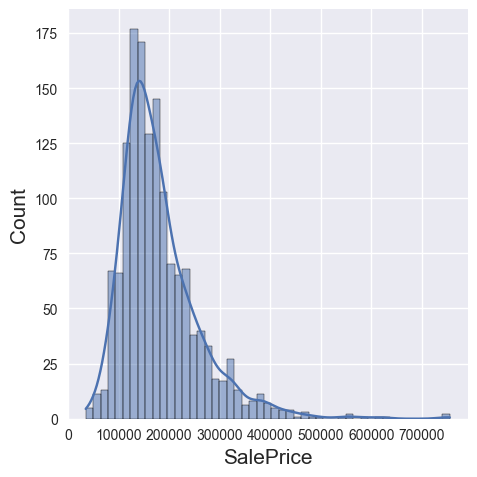

In [717]:
# distribution plot with normal fit
ax = sns.displot(data = train_raw['SalePrice'], kde=True)
plt.show()

The assocated p-value is : 3.2061412312021656e-33
With a threshold α = 0.05, we reject the null hypothesis


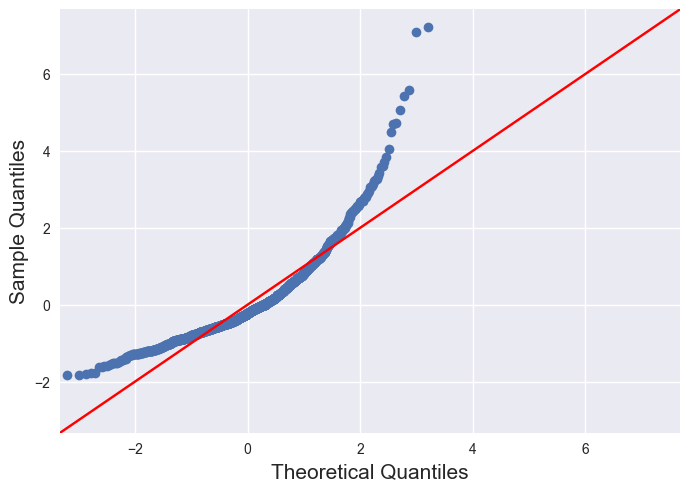

In [718]:
# Shapiro-Wilk Test for normality together with the Q-Q plot
alpha = 0.05
W, p = stats.shapiro(train_raw['SalePrice'])

print('The assocated p-value is : ' + str(p))

if p < alpha : 
    print('With a threshold α = ' + str(alpha) + ', we reject the null hypothesis')
else : 
    print('With a threshold α = ' + str(alpha) + ', we fail to reject the null hypothesis')
    
qqplot(train_raw['SalePrice'], dist = stats.distributions.norm, fit = True, line = '45')
plt.show()

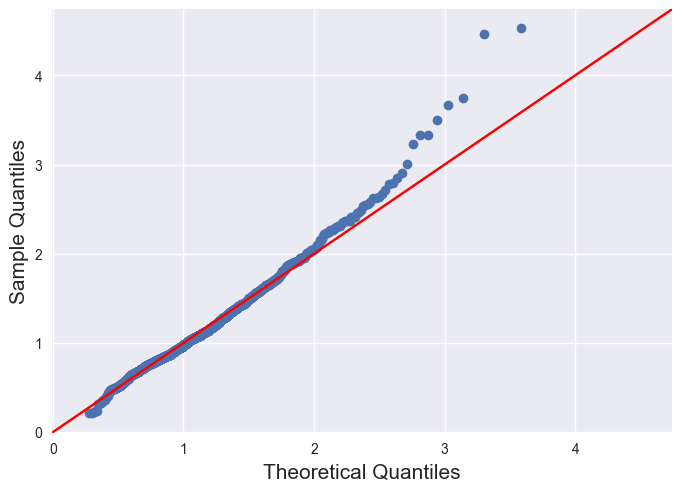

In [719]:
qqplot(train_raw['SalePrice'], dist = stats.distributions.lognorm, fit = True, line = '45')
plt.show()

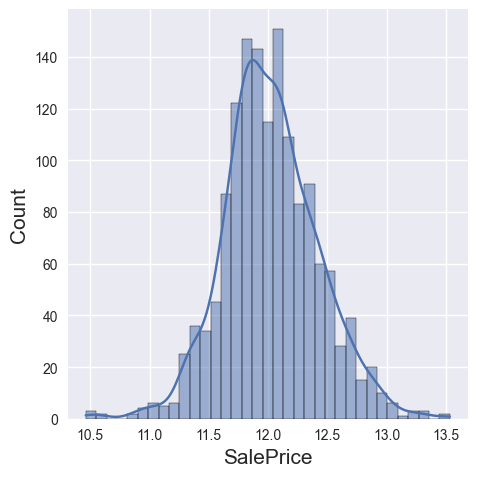

In [720]:
# new variable target which is the logarithm of the SalePrice
target = np.log1p(train_raw['SalePrice'])

# distribution plot
ax = sns.displot(data = target, kde=True)
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_39020\1467523942.py:16: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

C:\Users\david\AppData\Local\Temp\ipykernel_39020\1467523942.py:22: RuntimeWarning:

divide by zero encountered in divide



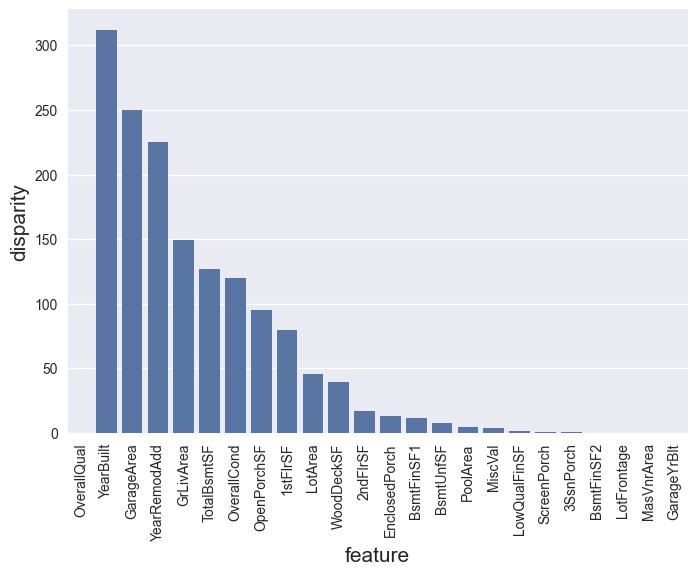

In [721]:
anova = anova(target, train_raw, numeric)

In [722]:
##anova = anova(target, train_raw, categorical)


## Model enginering

### Base pipeline

Nous nous sommes donc basés sur les travaux fournis lors du cours de Data Science pour établir notre pipeline. Dans un premier temps, il nous a fallu "nettoyer" le dataset

In [723]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

In [724]:
data_raw = pd.concat([train_raw, validation_raw])

Nous avons analysé et identifié les colonnes où il manquait des données.

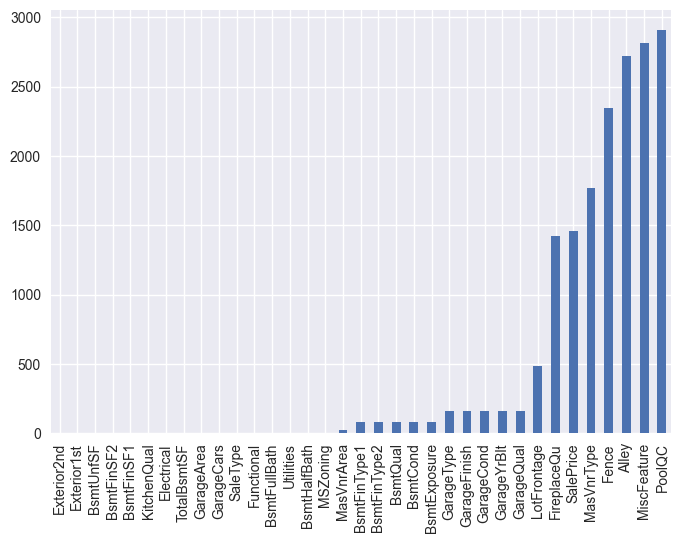

In [725]:
plot_missing(data_raw)

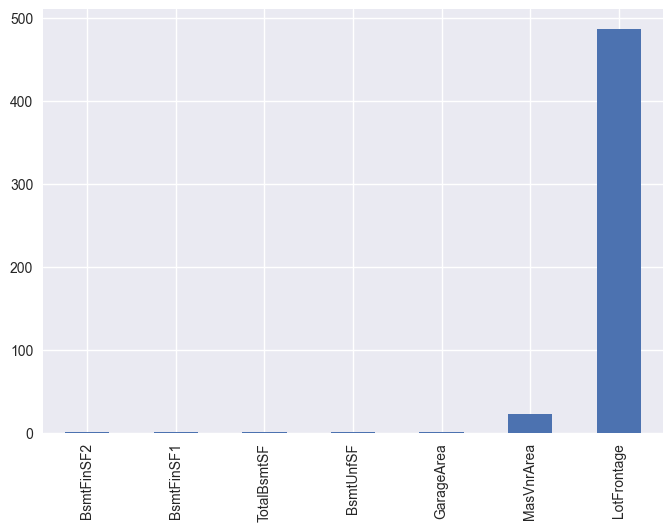

In [726]:
plot_missing(data_raw[quantitative])

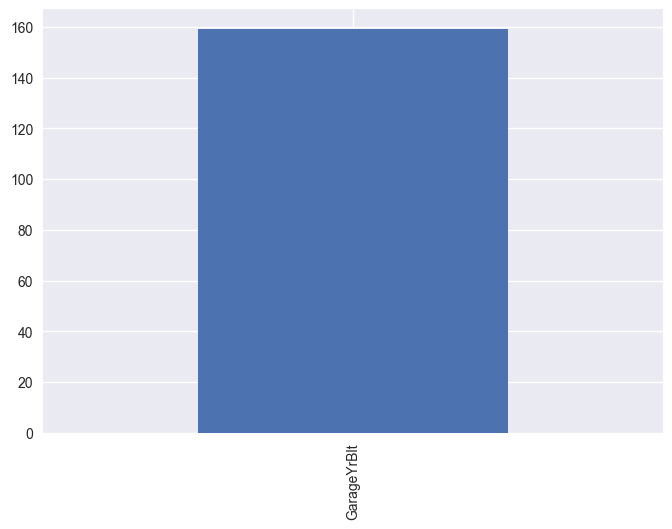

In [727]:
plot_missing(data_raw[date])

Nous avons ensuite nettoyer les données avec la fonction clean qui remplace les données quantitative manquante par 0, les qualtitatives par NA et l'année de construction

In [728]:
data_clean = clean(data_raw)

data_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0


In [729]:
# Split of the clean dataset into train & validation
train_clean = data_clean[data_clean.index.isin(train_raw.index)]
validation_clean = data_clean[data_clean.index.isin(validation_raw.index)]

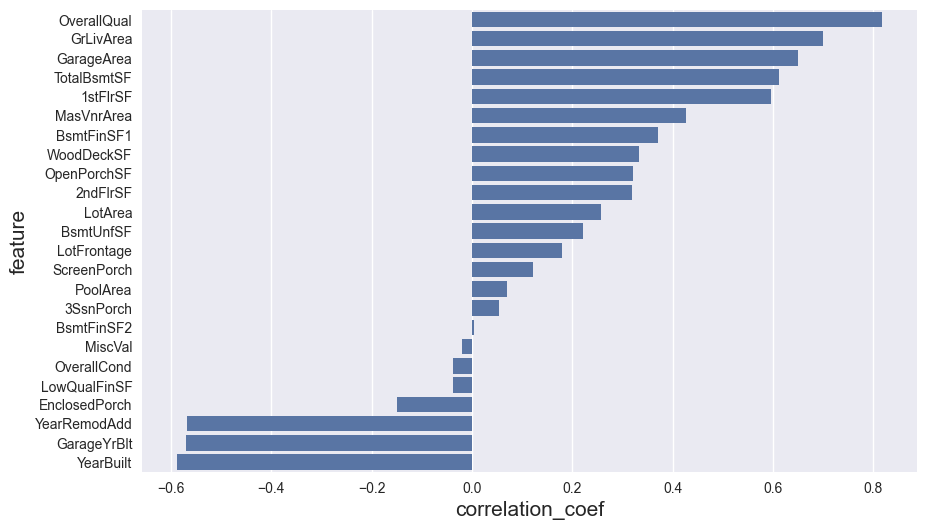

In [730]:
cor = correlation(target, train_clean, numeric, method = 'pearson')

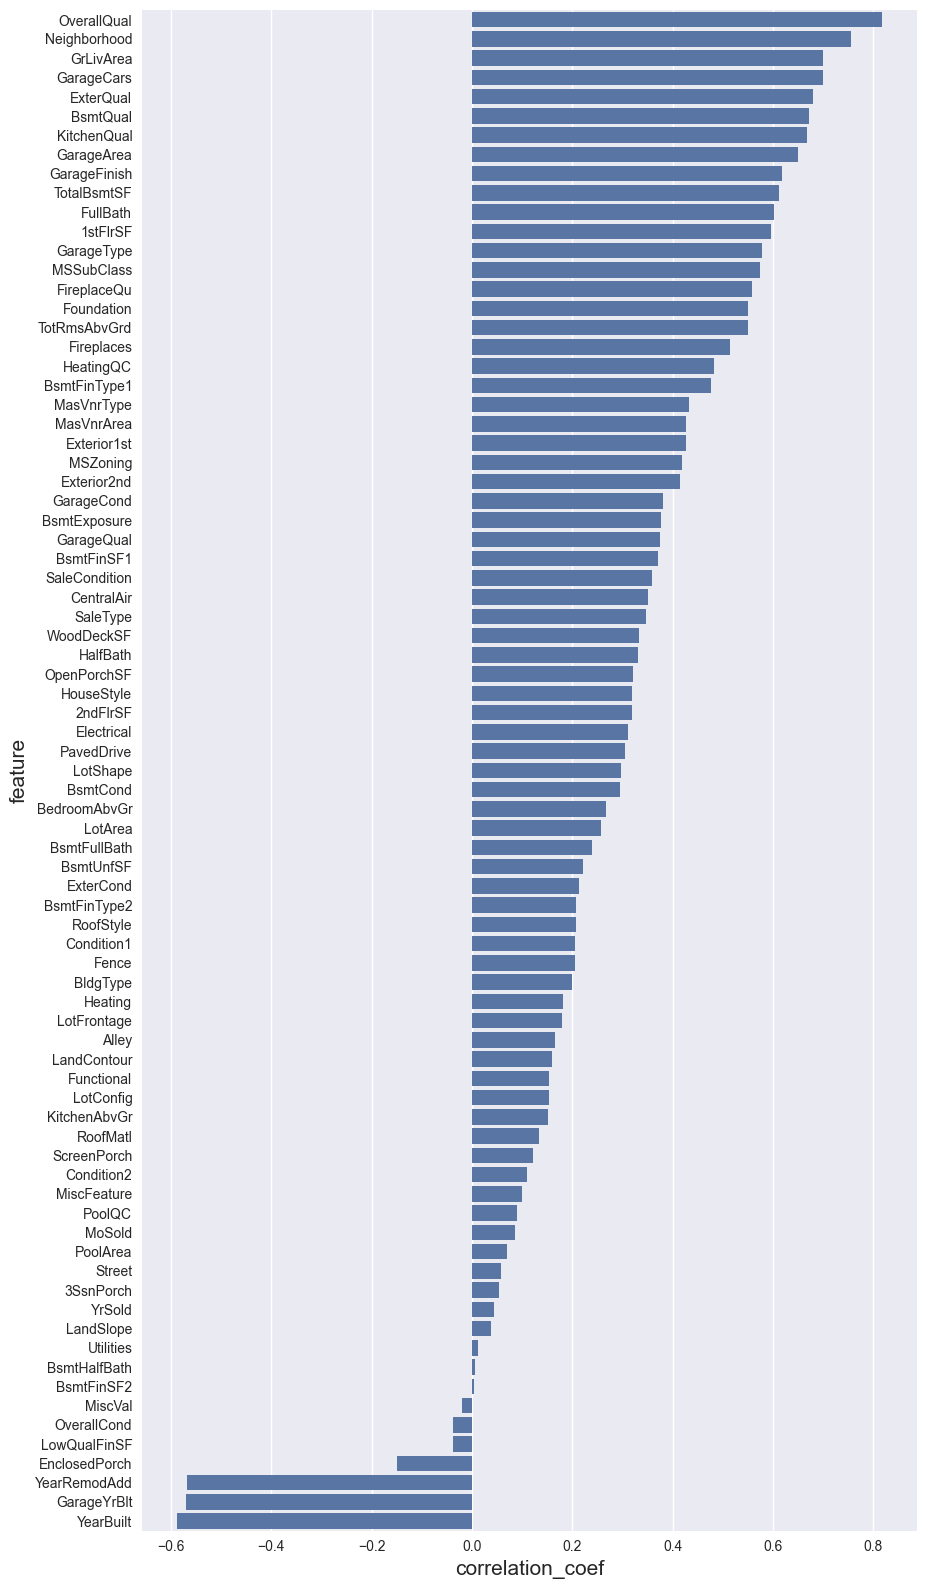

In [731]:
data_preprocess = encode_with_mean(data_clean, target, categorical)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_raw.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(validation_raw.index)]

cor = correlation(target, train_preprocess, numeric + categorical)

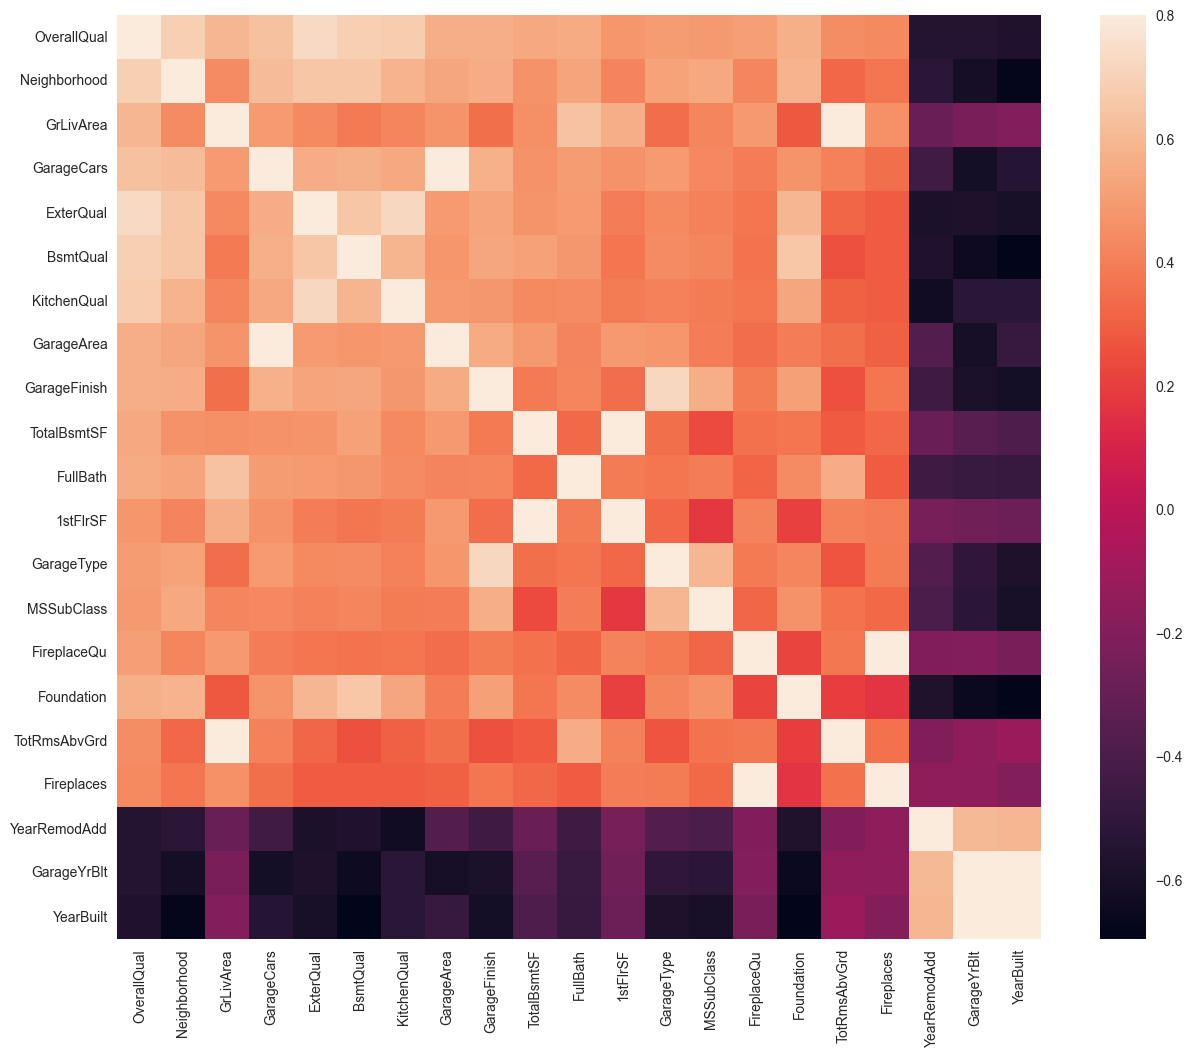

In [732]:
cols = cor[abs(cor['correlation_coef']) > 0.5]['feature'].tolist()
correlation_matrix = train_preprocess[cols].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

Using only this 5 columns

In [733]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [734]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:17:26   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

In [735]:
print(X[base].iloc[[523, 1298]])

      OverallQual  Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                                
524            10     11.712321       4676       3138.0          0
1299           10     11.712321       5642       6110.0          0


In [736]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.223436
2    12.099187
3    12.246534
4    12.098715
5    12.640468
dtype: float64


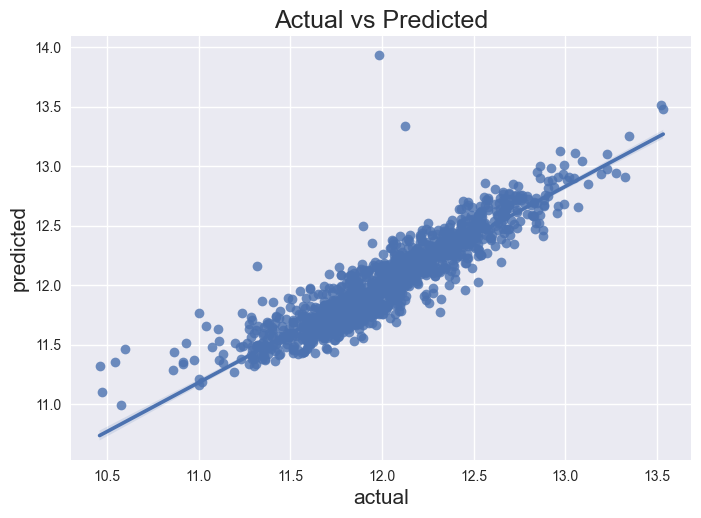

In [737]:
plot_prediction(y, y_pred)

In [ ]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.1672287156043483


In [739]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.681495
1462    11.925742
1463    12.018033
1464    12.103249
1465    12.389427
dtype: float64


In [740]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('baseline.csv', index = False)

Note obtenue sur Kaggle : 0.16914

### Model 1 - régression

Régression linéaire avec 10 colonnes triées et sélectionnées en fonction de notre cas métier. Ces colonnes sont les plus faciles à recenser pour notre banque et sont les informations que l'ont trouve en général sur une offre

Colonnes retenues :
- OverallQual : Qualité générale
- OverallCond : Condition générale
- Neighborhood : Quartier
- GrLivArea : Superficie de l'habitation
- LotArea : Superficie du terrain
- YearBuilt : Année de construction
- Foundation : Type de fondation
- TotRmsAbvGrd : Nombre de chambres, salles de bain exclues
- GarageArea : Taille du garage
- PoolArea : Taille de la piscine, 0 si pas à vérifier la pertinence


In [741]:
base = ['OverallQual', 'OverallCond', 'Neighborhood', 'GrLivArea', 'LotArea', 'YearBuilt', 'Foundation','TotRmsAbvGrd',
        'GarageArea', 'PoolArea']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [742]:
lasso_alphas = 10**np.linspace(-6,0,100)
lasso_alphas

array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-05, 2.15443469e-05, 2.47707636e-05,
       2.84803587e-05, 3.27454916e-05, 3.76493581e-05, 4.32876128e-05,
       4.97702356e-05, 5.72236766e-05, 6.57933225e-05, 7.56463328e-05,
       8.69749003e-05, 1.00000000e-04, 1.14975700e-04, 1.32194115e-04,
       1.51991108e-04, 1.74752840e-04, 2.00923300e-04, 2.31012970e-04,
       2.65608778e-04, 3.05385551e-04, 3.51119173e-04, 4.03701726e-04,
       4.64158883e-04, 5.33669923e-04, 6.13590727e-04, 7.05480231e-04,
       8.11130831e-04, 9.32603347e-04, 1.07226722e-03, 1.23284674e-03,
       1.41747416e-03, 1.62975083e-03, 1.87381742e-03, 2.15443469e-03,
      

Nous avons égale

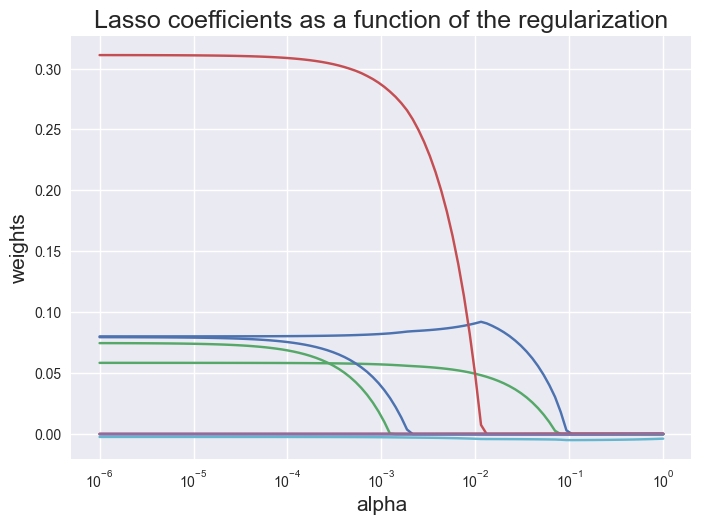

In [743]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso_regression = Lasso(max_iter=10000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X, y)
    lasso_coefs.append(lasso_regression.coef_)
    lasso_cv.append(cross_val_score(lasso_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

# Show the plot
plt.show()

In [744]:
ridge_alphas = 10**np.linspace(-3,5,100)
ridge_alphas

array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-02, 3.43046929e-02,
       4.13201240e-02, 4.97702356e-02, 5.99484250e-02, 7.22080902e-02,
       8.69749003e-02, 1.04761575e-01, 1.26185688e-01, 1.51991108e-01,
       1.83073828e-01, 2.20513074e-01, 2.65608778e-01, 3.19926714e-01,
       3.85352859e-01, 4.64158883e-01, 5.59081018e-01, 6.73415066e-01,
       8.11130831e-01, 9.77009957e-01, 1.17681195e+00, 1.41747416e+00,
       1.70735265e+00, 2.05651231e+00, 2.47707636e+00, 2.98364724e+00,
       3.59381366e+00, 4.32876128e+00, 5.21400829e+00, 6.28029144e+00,
       7.56463328e+00, 9.11162756e+00, 1.09749877e+01, 1.32194115e+01,
       1.59228279e+01, 1.91791026e+01, 2.31012970e+01, 2.78255940e+01,
      

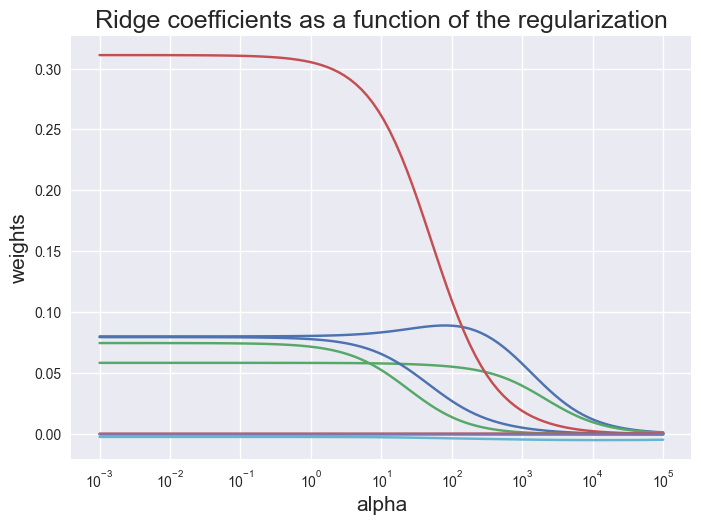

In [745]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge()
ridge_coefs = []
ridge_cv = []

for alpha in ridge_alphas:
    ridge_regression.set_params(alpha=alpha)
    ridge_regression.fit(X, y)
    ridge_coefs.append(ridge_regression.coef_)
    ridge_cv.append(cross_val_score(ridge_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(ridge_alphas, ridge_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

# Show the plot
plt.show()

In [746]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     839.8
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:17:29   Log-Likelihood:                 667.53
No. Observations:                1460   AIC:                            -1313.
Df Residuals:                    1449   BIC:                            -1255.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.2170      0.533      9.787   

In [747]:
print(X[base].iloc[[523, 1298]])

      OverallQual  OverallCond  Neighborhood  GrLivArea  LotArea  YearBuilt  \
Id                                                                            
524            10            5     11.712321       4676    40094          0   
1299           10            5     11.712321       5642    63887          0   

      Foundation  TotRmsAbvGrd  GarageArea  PoolArea  
Id                                                    
524     12.26167     12.549248       884.0         0  
1299    12.26167     12.412001      1418.0       480  


In [748]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.265541
2    12.191323
3    12.281445
4    12.062212
5    12.706889
dtype: float64


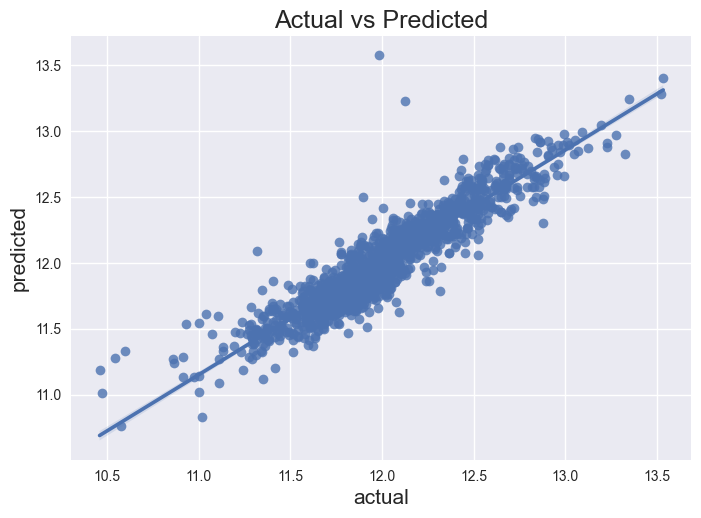

In [749]:
plot_prediction(y, y_pred)

In [750]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.15317901847157261


In [751]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.788707
1462    11.871535
1463    12.048191
1464    12.182522
1465    12.302147
dtype: float64


In [752]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('regression_linear_10_columns.csv', index = False)

Note obtenue sur Kaggle : 0.15715

On retire la colonne de la piscine car elle semble peu pertinente (très peu de data). En effet dans notre dataset d'entrainement, cette données n'a que très peu d'impact car très peu de maison sont dotées d'une piscine à Ames

In [753]:
base = ['OverallQual', 'OverallCond', 'Neighborhood', 'GrLivArea', 'LotArea', 'YearBuilt', 'Foundation','TotRmsAbvGrd',
        'GarageArea']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [754]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     932.4
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:17:29   Log-Likelihood:                 666.61
No. Observations:                1460   AIC:                            -1313.
Df Residuals:                    1450   BIC:                            -1260.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1085      0.527      9.691   

In [755]:
print(X[base].iloc[[523, 1298]])

      OverallQual  OverallCond  Neighborhood  GrLivArea  LotArea  YearBuilt  \
Id                                                                            
524            10            5     11.712321       4676    40094          0   
1299           10            5     11.712321       5642    63887          0   

      Foundation  TotRmsAbvGrd  GarageArea  
Id                                          
524     12.26167     12.549248       884.0  
1299    12.26167     12.412001      1418.0  


In [756]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.265650
2    12.192107
3    12.279595
4    12.062648
5    12.707154
dtype: float64


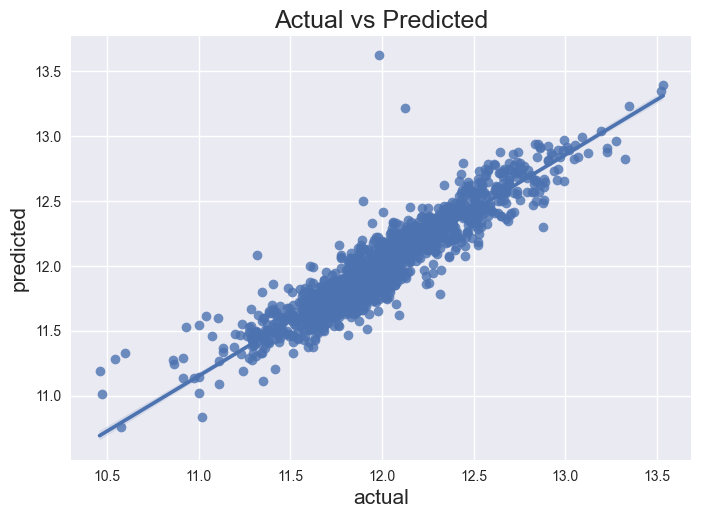

In [757]:
plot_prediction(y, y_pred)

In [758]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.15327565304506677


In [759]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.789320
1462    11.871071
1463    12.047016
1464    12.182648
1465    12.303040
dtype: float64


In [760]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('regression_linear_9_columns.csv', index = False)

**Model 2 : note obtenue sur Kaggle : 0.15694**


### Model 2 - XGboost

Comme second modèle, nous avons expérimenté l'utilisation d'XGboost pour tenter d'obtenir des meilleurs résultats de prédiction. On repart des 9 variables que nous avons sélectionnées lors du chapitre précédent.

In [761]:

import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Features used for XGBoost (reuse the same as previous model or select new ones)
xgb_features = ['OverallQual', 'OverallCond', 'Neighborhood', 'GrLivArea', 'LotArea', 'YearBuilt', 'Foundation','TotRmsAbvGrd', 'GarageArea']

X = train_preprocess[xgb_features]
X_val = validation_preprocess[xgb_features]
y = target.copy()

def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'alpha': trial.suggest_float('alpha', 1e-6, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-6, 10, log=True),
        'random_state': 42
    }
    model = XGBRegressor(objective='reg:squarederror', **params)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("best_params =", study.best_params, "with cross_validation_score =", study.best_value)


[I 2025-06-18 17:17:29,644] A new study created in memory with name: no-name-5da24332-116f-45d8-ab08-6fe271620877
[I 2025-06-18 17:17:29,732] Trial 0 finished with value: -0.14878601840069988 and parameters: {'eta': 0.01169616736057319, 'n_estimators': 306, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8038164789678548, 'colsample_bytree': 0.6603835686011901, 'gamma': 0.1415193178612496, 'alpha': 0.0005969577312799902, 'lambda': 3.084832547602782e-06}. Best is trial 0 with value: -0.14878601840069988.
[I 2025-06-18 17:17:29,777] Trial 1 finished with value: -0.14950809098535328 and parameters: {'eta': 0.16294044537536895, 'n_estimators': 287, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5152269393801887, 'colsample_bytree': 0.7240272753966351, 'gamma': 0.3115240339442784, 'alpha': 0.00026781205378371194, 'lambda': 0.013210802568948644}. Best is trial 0 with value: -0.14878601840069988.
[I 2025-06-18 17:17:29,843] Trial 2 finished with value: -0.1460679425442642 and par

best_params = {'eta': 0.0740625110593403, 'n_estimators': 359, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5443501552160215, 'colsample_bytree': 0.6758042104804309, 'gamma': 0.03775934909894762, 'alpha': 1.2931291739650032e-05, 'lambda': 0.02621345768260247} with cross_validation_score = -0.13954617647159612


In [762]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.14878601840069988, -0.14950809098535328,
                    -0.1460679425442642, -0.14539778573165132,
                    -0.14915175415312487, -0.1491533338622222, -0.1453318013751847,
                    -0.16015639880599442, -0.14918458411359622,
                    -0.1640847711524284, -0.15600060927235862,
                    -0.14675433207030725, -0.14870078641499213,
                    -0.14912193131089846, -0.14380773699048566,
                    -0.14510850897524097, -0.14737956312578024,
                    -0.1453473714670511, -0.15348914440467568, -0.1543185197514342,
                    -0.14320196220728362, -0.14340213850473793,
                    -0.1460422405034895, -0.14696360021291915,
                    -0.14308614372371167, -0.14287702110489672,
                    -0.14266575033616868, -0.14425278518891443,
                    -0.14407783619626616, -0.14453500507961414,
                    -0.13954617647159612, -0.14250342176237235,
                    -0.1395856405715621, -0.14355832004545035,
                    -0.14427597911239481, -0.1430820313241674,
                    -0.14445464483464163, -0.14908066637577794,
                    -0.1430728492803462, -0.14358195834748272,
                    -0.14064161066479947, -0.14127407460101776,
                    -0.13977514167878233, -0.1404323081459956, -0.1435540886422747,
                    -0.14127579893696032, -0.14569127049063024,
                    -0.14374302928689242, -0.14158046282993958,
                    -0.14934050632265644]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [-0.14878601840069988, -0.14878601840069988,
                    -0.1460679425442642, -0.14539778573165132,
                    -0.14539778573165132, -0.14539778573165132,
                    -0.1453318013751847, -0.1453318013751847, -0.1453318013751847,
                    -0.1453318013751847, -0.1453318013751847, -0.1453318013751847,
                    -0.1453318013751847, -0.1453318013751847, -0.14380773699048566,
                    -0.14380773699048566, -0.14380773699048566,
                    -0.14380773699048566, -0.14380773699048566,
                    -0.14380773699048566, -0.14320196220728362,
                    -0.14320196220728362, -0.14320196220728362,
                    -0.14320196220728362, -0.14308614372371167,
                    -0.14287702110489672, -0.14266575033616868,
                    -0.14266575033616868, -0.14266575033616868,
                    -0.14266575033616868, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612, -0.13954617647159612,
                    -0.13954617647159612]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'sho

In [763]:
# Train final model with best params
best_params = study.best_params
model = XGBRegressor(objective='reg:squarederror', **best_params)
model.fit(X, y)

y_pred = model.predict(X)
print("Train RMSE:", rmse(y, y_pred))

# Predict on validation set
y_val_pred = model.predict(X_val)
print("Validation predictions (log1p):", y_val_pred[:5])

# Prepare submission
submission = pd.DataFrame()
submission['Id'] = X_val.index
submission['SalePrice'] = np.expm1(y_val_pred)
submission.to_csv('xgboost_optuna.csv', index=False)

Train RMSE: 0.09201386503236658
Validation predictions (log1p): [11.801183 11.963065 12.079607 12.155768 12.223206]


**Model 2 : note obtenue sur Kaggle : 0.14336**

### Model 3



### Model 4



## Cadre juridique et considérations éthiques
Dans un contexte de digitalisation accrue des processus bancaires, le recours à des systèmes d’aide à la décision basés sur l’intelligence artificielle (IA) offre de nouvelles opportunités pour renforcer la fiabilité des évaluations de risque. Ce projet s’inscrit dans cette dynamique, en explorant l’apport de la data science dans un cas d’usage concret lié au financement hypothécaire.

### Prédiction du prix de biens immobiliers
Banklytics est une banque nord-américaine spécialisée dans les prêts hypothécaires. Afin de sécuriser l’octroi de ses crédits, elle souhaite disposer d’un outil capable d’estimer la valeur réelle d’un bien immobilier, sur la base de ses caractéristiques techniques et contextuelles, avant de valider un prêt.

L’objectif est d’éviter que le montant de l’hypothèque dépasse la valeur réelle du bien, ce qui exposerait la banque à des pertes en cas de défaut de paiement. Le modèle prédictif envisagé permettrait ainsi de soutenir les décisions des analystes crédit, en évaluant la cohérence entre le prix de vente déclaré et la valeur estimée du bien.

Un premier prototype est développé à partir d’un dataset de référence public, issu de transactions immobilières réelles enregistrées dans la ville d’Ames (Iowa, États-Unis). Ce jeu de données, bien que daté, permet d’évaluer la faisabilité technique du modèle et sa robustesse algorithmique.

### Cadre réglementaire applicable (USA)
La conception et l’utilisation d’un tel modèle prédictif sont soumises à plusieurs cadres juridiques spécifiques au contexte américain :

#### Fair Lending Laws
Conformément au Fair Housing Act et à l’Equal Credit Opportunity Act (ECOA), toute décision d’octroi de prêt doit garantir une égalité de traitement. L’utilisation d’un modèle algorithmique ne doit pas induire de biais ou de discriminations, même indirectes.

#### AVM Regulatory Requirements
Si le modèle est utilisé comme un Automated Valuation Model (AVM) dans le processus de décision, il doit respecter les interagency guidelines en vigueur, notamment en matière de documentation, robustesse et auditabilité.

#### Obligations de transparence et de justification
En cas de refus de crédit, les clients ont le droit de recevoir une explication claire des motifs de la décision, y compris lorsque celle-ci est influencée par un système algorithmique.

#### Protection des données (Etats spécifiques)
Bien que le dataset utilisé ici soit public et anonymisé, tout déploiement ultérieur devra être conforme aux lois en vigueur sur la protection des données personnelles, telles que le California Consumer Privacy Act (CCPA) ou d’autres lois étatiques similaires.

### Application volontaire du cadre européen
Bien que ce cas d’usage soit situé en Amérique du Nord et soumis en priorité aux régulations locales mentionnées ci-dessus, une analyse complémentaire a été menée à la lumière du règlement européen sur l’intelligence artificielle (AI Act), récemment adopté par l’Union européenne.

Cette démarche vise à anticiper les bonnes pratiques internationales en matière de conception responsable de systèmes d’IA, et à garantir une portabilité réglementaire en cas de déploiement futur dans d’autres juridictions, y compris européennes.

Dans ce cadre, le système de prédiction de la valeur immobilière est considéré comme un système d’IA à risque élevé (high-risk AI system), au sens de l’AI Act, s’il est utilisé directement pour l’évaluation de la solvabilité ou pour influencer une décision ayant un impact juridique ou significatif sur une personne physique (ex. : refus de crédit hypothécaire).

En conséquence, les exigences suivantes ont été prises en compte dans la conception :

- Documentation rigoureuse du modèle (données, performances, limites, biais éventuels)
- Transparence sur les objectifs et le fonctionnement du système
- Contrôles humains intégrés dans le processus décisionnel (human-in-the-loop)
- Mesures pour limiter les risques de discrimination indirecte
- Journalisation des décisions algorithmiques à des fins d’auditabilité

Cette approche nous permet non seulement d’améliorer la robustesse éthique et technique du système, mais aussi de préparer un alignement futur avec les cadres réglementaires internationaux, dans un contexte de plus en plus harmonisé autour de l’IA responsable.

### Considération éthiques
En complément de l’analyse réglementaire, la conception de ce projet tient compte des valeurs fondamentales européennes en matière d’intelligence artificielle, telles que définies par la Commission européenne dans ses travaux sur l’IA digne de confiance (Trustworthy AI). Bien que le projet soit situé en Amérique du Nord, ces principes ont été volontairement intégrés à titre de référentiel éthique exigeant.

Les grands piliers éthiques retenus sont les suivants :

### Respect des droits fondamentaux
Le modèle ne doit en aucun cas porter atteinte à la dignité humaine, à la vie privée, ou au droit à l’égalité de traitement. Des efforts spécifiques sont déployés pour éviter tout biais algorithmique pouvant produire des discriminations indirectes, en particulier lors de la sélection des variables prédictives.

### Contrôle humain (Human Agency and Oversight)
Le système est conçu pour assister les analystes dans la prise de décision, sans les remplacer. La décision finale d’octroi ou de refus de prêt reste entre les mains d’un expert humain, garantissant un niveau de contrôle, de contextualisation et de responsabilité adapté.

### Transparence et explicabilité
Les utilisateurs internes du modèle (analystes crédit) disposent d’un accès aux facteurs influents de la prédiction. L’approche inclut l’intégration d’outils d’interprétabilité des modèles (type SHAP ou LIME), dans le but de garantir une explication claire et justifiable des décisions algorithmiques.

### Robustesse technique et sécurité
Le modèle fait l’objet de tests continus, incluant la gestion des valeurs aberrantes, des variables manquantes et des cas limites. Des mécanismes sont prévus pour limiter les effets de dérive si les données futures évoluent (concept drift).

### Inclusion et équité
Une attention particulière est portée à la représentativité des données, en particulier pour s’assurer que les biens immobiliers de zones ou segments socio-économiques spécifiques ne soient pas systématiquement sous-évalués. Cette vigilance vise à éviter toute forme d’exclusion financière indirecte.

### Responsabilité
Une traçabilité complète est assurée à travers la documentation du projet, des choix méthodologiques et des justifications réglementaires. En cas de contestation, les décisions issues du modèle peuvent être revues et explicitées, garantissant un droit à la compréhension et à la contestation.